# Transfer Learning with TensorFlow part-2: Fine Tuning

In the previous notebook, we have covered transfer learning feature extraction, now it's time to learn a new kind of transfer learning: **Fine Tuning**

In [ ]:
# Check whether we are using GPU or not
!nvidia-smi


Wed Feb 15 15:50:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper functions

In the previous notebooks, we have created a bunch of helper functions, now we can rewrite them all, however this is tedious.

It's a good idea to put functions that you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-15 15:50:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-15 15:50:48 (94.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import the helper that we are going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you are running this notebook in Google Colab, when it's time out Google Colab will delete `helper_functions`, so we'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we are going to see how we can us the pretrained models within `tf.keras.applications` and apply them to our own problems (recognizing images of food)

In [ ]:
# Let's get the 10% of training data of 10 food classes

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

# Or we can call the unzip_data method from the helper_functions
# unzip_data("10_food_classes_10_percent.zip")

--2023-02-15 15:50:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   211MB/s    in 0.8s    

2023-02-15 15:50:53 (211 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Let's walk through the directory and find the files and folders in the directory
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

# Or we can call the walk_through_dir method from the helper_functions file
# walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 files in '10_food_classes_10_percent'.
There are 10 directories and 0 files in '10_food_classes_10_percent/train'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/steak

In [ ]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# # Let's create objects of ImageDataGenerator class
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1/255.0)
# test_datagen = ImageDataGenerator(rescale=1/255.0)

# train_data = train_datagen.flow_from_directory(train_dir,
#                                                target_size=(224, 224),
#                                                batch_size=32,
#                                                class_mode='categorical')

# test_data = test_datagen.flow_from_directory(test_dir,
#                                              target_size=(224, 224),
#                                              batch_size=32,
#                                              class_mode="categorical")

In [ ]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode='categorical')

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Checkout the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 21.17347    16.17347    12.403061 ]
   [ 20.790817   18.454082   13.4540825]
   [ 19.857143   18.637756   14.72449  ]
   ...
   [ 13.214264   14.         15.571472 ]
   [ 14.         14.         13.857117 ]
   [ 17.         13.         11.285645 ]]

  [[ 18.168367   14.168366   13.739796 ]
   [ 19.918367   15.984694   12.984694 ]
   [ 20.89796     9.071427    2.6887736]
   ...
   [ 13.943876   14.         15.173553 ]
   [ 14.         14.         13.989794 ]
   [ 17.         13.         11.285645 ]]

  [[ 15.153061   13.07653    17.219389 ]
   [ 17.571426   12.045917    9.530609 ]
   [ 38.408165   15.27041     3.8724494]
   ...
   [ 14.306091   13.954086   15.142944 ]
   [ 14.         14.         14.397954 ]
   [ 15.561279   13.71936    12.       ]]

  ...

  [[ 13.77041    12.341882    8.127618 ]
   [ 22.469368   17.5561     13.199001 ]
   [ 32.454308   16.219666    6.9593787]
   ...
   [ 48.728718   48.300186   50.514454 ]
   [ 18.887915   18.887915   20.887915 ]
   [ 

## Model 0: Building a transfer learning feature extraction model using the Keras Functional APIs

The sequential api is straight-forward, it runs over the layers in sequential manner.

But the functional api gives us more flexibility with our model

In [ ]:
# 1. Create the base model with the tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so, the underlying pre-trained pattern are not updated)
base_model.trainable = False

# 3. Create inputs in our model
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,), name='input_layer')

# 4. If using models like ResNet50V2 you will need to noramlize the data (don't need to do in efficientnet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255.0)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs to the base model: {x.shape}.")

# 6. Average pool the output of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after the GlobalAveragePooling2D: {x.shape}.")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs in a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=20,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='10_percent_feature_extraction')])

16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inputs to the base model: (None, 7, 7, 1280).
Shape after the GlobalAveragePooling2D: (None, 1280).
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230215-155101
Epoch 1/20
24/24 [==============================] - 19s 250ms/step - loss: 1.7883 - accuracy: 0.4493 - val_loss: 1.2765 - val_accuracy: 0.7122
Epoch 2/20
24/24 [==============================] - 4s 131ms/step - loss: 1.0738 - accuracy: 0.7653 - val_loss: 0.8910 - val_accuracy: 0.7895
Epoch 3/20
24/24 [==============================] - 4s 132ms/step - loss: 0.7880 - accuracy: 0.8293 - val_loss: 0.7190 - val_accuracy: 0.8224
Epoch 4/20
24/24 [==============================] - 5s 173ms/step - loss: 0.6324 - accuracy: 0.8640 - val_loss: 0.6128 - val_accuracy: 0.8322
Epoch 5/20
24/24 [==============================] - 4s 134ms/step - loss: 0.5351 - accuracy: 0.8840 - val_loss: 0.5653 - val_accuracy: 0.8470
Epoch 6/20
24/24 [==============================] - 5s 174ms/step - loss

In [ ]:
# Evaluate on the test data
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.3857 - accuracy: 0.8780


[0.3857247829437256, 0.878000020980835]

In [ ]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# How about we get the summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


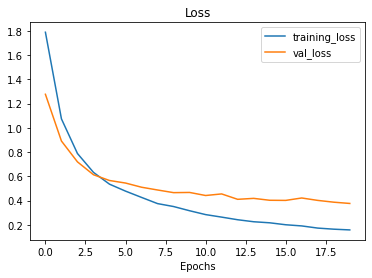

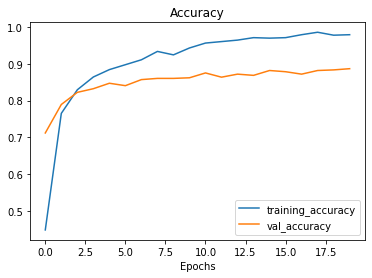

In [ ]:
# Check out loss curves
plot_loss_curves(history_0)

## Getting a Feature Vector from the trained model

Let's demonstrate the GlobalAveragePooling2D layer.

We have a tensor after our model goes to `base_model` of shape (None, 7, 7, 1280).

But when it passes through the GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(43)
input_tensor = tf.random.normal(input_shape)
print(f"Random Tensor:\n {input_tensor}\n")

# Pass the random tensor to the GlobalAveragePolling2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Global Average Pooled Tensor: \n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of the Global Average Pooled Tensor: {global_average_pooled_tensor.shape}")

Random Tensor:
 [[[[-0.02050048 -1.6105652  -0.72483575]
   [-0.5450064   1.0539695  -0.891284  ]
   [ 0.09752923 -1.1036574   0.47783953]
   [ 0.18255234 -0.23718892  0.31086874]]

  [[ 0.15652822 -0.88578725 -1.1723399 ]
   [ 1.2841821   1.248613   -1.2372904 ]
   [-0.8686831  -0.44940874  0.4442081 ]
   [ 1.4079124  -1.3365219   3.2284563 ]]

  [[-1.9076515   0.17897357  0.08237003]
   [-1.0684288   1.2464011  -0.39724466]
   [-0.5205348  -0.2745581   1.9562448 ]
   [-3.0211666   0.36173433  0.15002829]]

  [[-0.03679373  1.0056065   1.2866769 ]
   [-0.24367902 -0.32192045  0.11693916]
   [-0.97043836 -2.1374395  -0.10489912]
   [ 1.6242274   0.72912854  0.82555187]]]]

Global Average Pooled Tensor: 
[[-0.27812195 -0.1582888   0.2719556 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of the Global Average Pooled Tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePooling2D layer
tf.math.reduce_mean(input_tensor, axis=[1, 2])

# Global Average Pooling 2D layer just find the mean along the 1 and 2nd axis.

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.27812195, -0.1582888 ,  0.2719556 ]], dtype=float32)>

In [ ]:
# Let's check the GlobalMaxPooling2D layer for the above input_tensor
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"Global Max Pooled Tensor: \n{global_max_pooled_tensor}")

# Check the shape of the above tensors
print(f"Shape of the Global Max Pooled Tensor: {global_max_pooled_tensor}")

Global Max Pooled Tensor: 
[[1.6242274 1.248613  3.2284563]]
Shape of the Global Max Pooled Tensor: [[1.6242274 1.248613  3.2284563]]


In [ ]:
# Let's replicate the GlobalMaxPooling2D Layer
tf.math.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.6242274, 1.248613 , 3.2284563]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get only on 10% training dataset, but how does it goes with only 1% of the training data...how about we setup a bunch of experiments to find it out:

1. `model_1`- use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation.

> **Note:** Throughout all the experiments, the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

In [ ]:
# Download the 1% dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip the data
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-15 15:52:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   200MB/s    in 0.6s    

2023-02-15 15:53:00 (200 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Setting the train and test directory path
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images we are working with?
for dirpath, dirnames, filenames in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 2 directories and 0 files in '10_food_classes_1_percent'
There are 10 directories and 0 files in '10_food_classes_1_percent/train'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/grilled_salmon'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/chicken_curry'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/ramen'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/sushi'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/pizza'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/hamburger'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/fried_rice'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/ice_cream'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/chicken_wings'
There are 0 directories and 7 files in '10_food_classes_1_percent/train/steak'
There are 10 directories and 0 

In [ ]:
# load the dataset
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMAGE_SIZE,
                                                                                 batch_size=BATCH_SIZE)  # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      label_mode='categorical',
                                                                      image_size=IMAGE_SIZE,
                                                                      batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside: `tf.keras.layers.experimental.preprocessing()`.

Off the top pf jeads. after reading the docs, the benefits of using data augmentation insede the model are:
* Preprocessing of images (augmenting them) happens on GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.

data_augmentation = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1/255.0) # keep for models like resnet50v2 but efficientnetb0 has built-in.
], name='data_augmentation')

# Turned on only during the training of the model, but turned off during inference (does not augment testing data)

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 500.5, 602.5, -0.5)

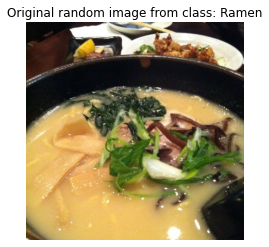

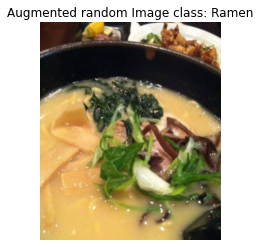

In [ ]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class.title()}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_image = data_augmentation(img, training=True)
plt.figure() # The figure() method is used to create a new figure.
plt.imshow(augmented_image/255.0)
plt.title(f"Augmented random Image class: {target_class.title()}")
plt.axis(False)

## Model 1: Feature Extraction transfer learning on 1% of the training data

In [ ]:
# Setup input shape and the base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give the base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as output
outputs = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=20,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),  # validation the model only on 25 of the test data
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230215-155306
Epoch 1/20


3/3 [==============================] - ETA: 0s - loss: 2.3693 - accuracy: 0.1857

3/3 [==============================] - 14s 2s/step - loss: 2.3693 - accuracy: 0.1857 - val_loss: 2.2863 - val_accuracy: 0.1217
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 2.1403 - accuracy: 0.2571 - val_loss: 2.1383 - val_accuracy: 0.1908
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 1.9527 - accuracy: 0.3857 - val_loss: 2.0436 - val_accuracy: 0.2911
Epoch 4/20
3/3 [==============================] - 4s 2s/step - loss: 1.7660 - accuracy: 0.5429 - val_loss: 1.9105 - val_accuracy: 0.4030
Epoch 5/20
3/3 [==============================] - 4s 2s/step - loss: 1.7300 - accuracy: 0.5571 - val_loss: 1.8316 - val_accuracy: 0.4539
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 1.4625 - accuracy: 0.6857 - val_loss: 1.7395 - val_accuracy: 0.4967
Epoch 7/20
3/3 [==============================] - 4s 2s/step - loss: 1.3188 - accuracy: 0.7143 - val_loss: 1.6535 - val_accuracy: 0.5280
Epoch 8/20
3/3 [==============================] - 4

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [ ]:
# Check the summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate the model on full testing data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 71ms/step - loss: 1.1118 - accuracy: 0.6948


[1.1117912530899048, 0.6948000192642212]

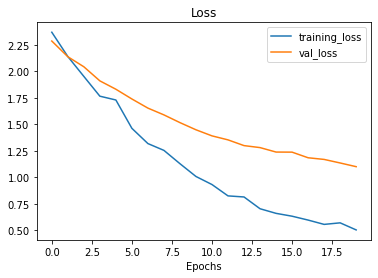

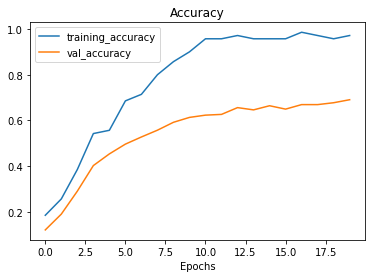

In [ ]:
# Plot the loss curves
plot_loss_curves(history_1)

## Model_2: Same as model_0 with data augmentation

In [ ]:
# Augmenting the data
data_augmentation_10_percent = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale() # Add it in models like resnet50v2 but in efficientnet it already implemented.
], name='augmentation_layer')


(-0.5, 513.5, 454.5, -0.5)

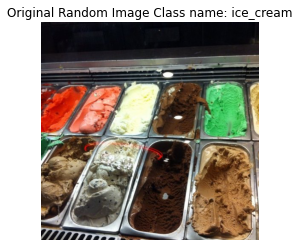

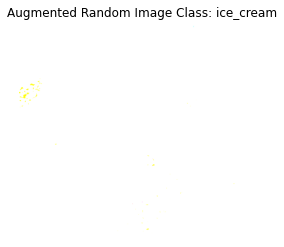

In [ ]:
# Now let's visualize a random image from the 10_food_classes_10_percent dataset

random_class = random.choice(train_data_10_percent.class_names)
target_dir = "10_food_classes_10_percent/train/" + random_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Plot the original image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original Random Image Class name: {random_class}")
plt.axis(False)

# Plot the augmented image
augmented_image = data_augmentation_10_percent(img)
plt.figure()
plt.imshow(augmented_image)
plt.title(f"Augmented Random Image Class: {random_class}")
plt.axis('off')

In [ ]:
# Now let's train the Functional Api model on the 10% percent training data
input_shape = (224, 224, 3)

# Creating the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape,
                               name='input_layer')
# Pass the inputs to the data augmentation sequential layer
x = data_augmentation_10_percent(inputs)

# Give the base model the inputs and set training = False
x = base_model(x, training=False)

# Add a global average pooling 2d layer on top of the base model
# x = tf.keras.layers.GlobalAveragePolling2D(name='global_average_pooling_layer')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Add the output layer
outputs = tf.keras.layers.Dense(units=10,
                                activation='softmax',
                                name='output_layer')(x)

# Pass the inputs and output to the Model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model_2
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


## Creating a ModelCheckpoint Callback

The **ModelCheckpoint** Callback intermediately saves our model (the full model or just weights) during training. This is useful as we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Creating a modelcheckpoint callback that only save the model's weight
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=20,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                experiment_name='10_percent_data_aug'),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230215-155501
Epoch 1/20


24/24 [==============================] - ETA: 0s - loss: 1.9932 - accuracy: 0.3627


Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 23s 628ms/step - loss: 1.9932 - accuracy: 0.3627 - val_loss: 1.4041 - val_accuracy: 0.7056
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 1.2899 - accuracy: 0.7067
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 558ms/step - loss: 1.2899 - accuracy: 0.7067 - val_loss: 0.9269 - val_accuracy: 0.8405
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 1.0023 - accuracy: 0.7627
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 484ms/step - loss: 1.0023 - accuracy: 0.7627 - val_loss: 0.7343 - val_accuracy: 0.8618
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.8289 - accuracy: 0.8107
Epoch 4: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24

In [ ]:
# Evaluate the model on the complete test data
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 6s 65ms/step - loss: 0.4221 - accuracy: 0.8720


[0.4220816493034363, 0.871999979019165]

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, 3)          0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

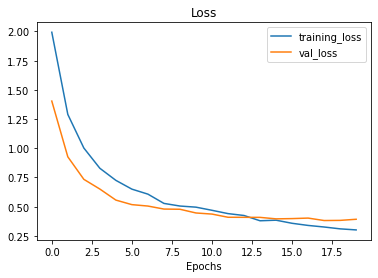

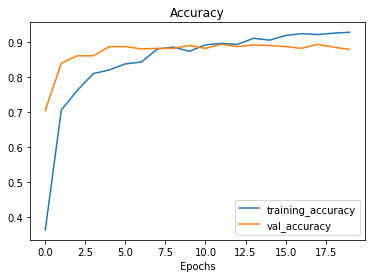

In [ ]:
# Plot the loss curves
plot_loss_curves(history_2)

### Loading Checkpointed Weights

Loading in checkpointed weights returns a model to a specific checkpoing

In [ ]:
# Load the save model and evaluate it on the test data

model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 on the loaded weights
loaded_weights_model_result = model_2.evaluate(test_data)


79/79 [==============================] - 6s 65ms/step - loss: 0.4221 - accuracy: 0.8720


In [ ]:
# If the result from our previously evaluated model 2 matches the loaded weights everything works
loaded_weights_model_result == result_10_percent_data_aug

False

In [ ]:
result_10_percent_data_aug

[0.4220816493034363, 0.871999979019165]

In [ ]:
loaded_weights_model_result

[0.4220817983150482, 0.871999979019165]

In [ ]:
import numpy as np

np.isclose(result_10_percent_data_aug, loaded_weights_model_result)

array([ True,  True])

In [ ]:
# Check the difference between two results
print(np.array(loaded_weights_model_result) - np.array(result_10_percent_data_aug))

[1.49011612e-07 0.00000000e+00]


## Model 3: Fine-Tuning an existing model on 10% training data

> **Note:** Fine tuning works best after training a feature extraction model for few epochs with data.

In [ ]:
# Layers in the loaded model_2
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9c177212b0> True
<keras.engine.sequential.Sequential object at 0x7f9c0b09b400> True
<keras.engine.functional.Functional object at 0x7f9c0aee5190> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f9c801e8850> True
<keras.layers.core.dense.Dense object at 0x7f9c0abb8430> True


In [ ]:
# What are the layers in our base model (efficientnetb0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# how many trainable variables are there in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable = True

# Freeze all layerse except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (we have to recompile our model every time we make changes)
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=0.00001), # when fine tunig we typically lower the value of learning rate by 10X.
                metrics=['accuracy'])



>**Note:** When using fine-tuning it's best practice to lower the learning rate by some amount.
How much? This is a hyperparameter you can tune.
But a good rule of thumb is atleast 10x. (though different sources will clain different values).
A good resource for information on this is ULMFIT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable(trainable)?
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables?
print(len(model_2.layers[2].trainable_variables), len(model_2.trainable_variables))

10 12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine tune for another 20 epochs
initial_epochs = 20
fine_tune_epochs = initial_epochs + 20

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_2.epoch[-1], # start training from previous epoch left
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230215-160100
Epoch 20/40


24/24 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.8640

24/24 [==============================] - 25s 538ms/step - loss: 0.1314 - accuracy: 0.8640 - val_loss: 0.1013 - val_accuracy: 0.8618
Epoch 21/40
24/24 [==============================] - 11s 425ms/step - loss: 0.0715 - accuracy: 0.9053 - val_loss: 0.0834 - val_accuracy: 0.8865
Epoch 22/40
24/24 [==============================] - 11s 449ms/step - loss: 0.0455 - accuracy: 0.9600 - val_loss: 0.0720 - val_accuracy: 0.9062
Epoch 23/40
24/24 [==============================] - 11s 427ms/step - loss: 0.0310 - accuracy: 0.9787 - val_loss: 0.0802 - val_accuracy: 0.8947
Epoch 24/40
24/24 [==============================] - 9s 381ms/step - loss: 0.0236 - accuracy: 0.9853 - val_loss: 0.0855 - val_accuracy: 0.8914
Epoch 25/40
24/24 [==============================] - 10s 399ms/step - loss: 0.0210 - accuracy: 0.9867 - val_loss: 0.0801 - val_accuracy: 0.8849
Epoch 26/40
24/24 [==============================] - 9s 363ms/step - loss: 0.0184 - accuracy: 0.9920 - val_loss: 0.0940 - val_accuracy: 0.8766
Epoch 

In [ ]:
# Evaluate the fine tuned model (model 3 which is actually model 2 trained for 20 more epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.1079 - accuracy: 0.8788


In [ ]:
results_fine_tune_10_percent

[0.10793434828519821, 0.8787999749183655]

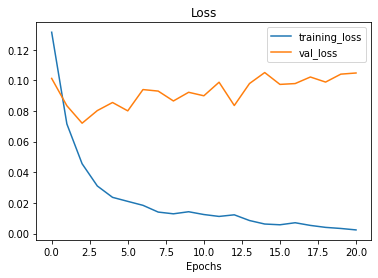

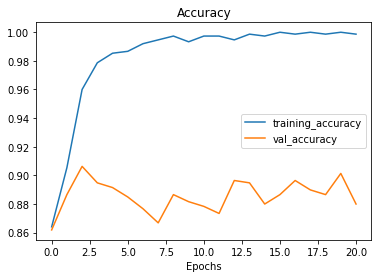

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves()` function works great with models that being fit only once, however we want something to compare one series of running `fit()` to another (e.g. before and after fine-tuning)

In [ ]:
# Let make a function to compare the histories

def compare_histories(original_history, new_history, initial_epochs=20):
  """
  Compare histories of two different objects.
  """

  # get original history measurements
  accuracy = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_accuracy = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combining the two metrics
  total_accuracy = accuracy + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_accuracy = val_accuracy + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots of accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_accuracy, label='Training Accuracy')
  plt.plot(total_val_accuracy, label='Validation Accuracy')
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


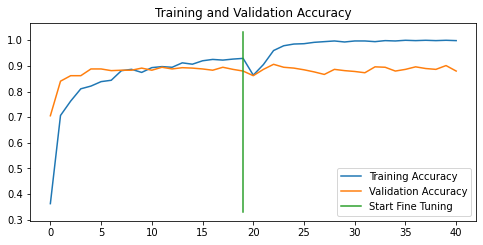

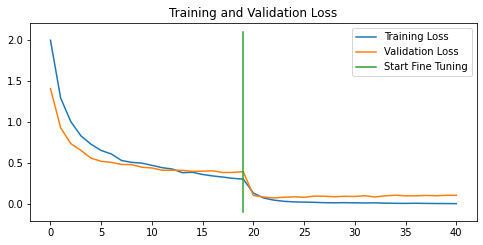

In [ ]:
compare_histories(history_2, history_fine_10_percent_data_aug)

## Model 4: Fine-Tuning on all training data

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

--2023-02-15 16:04:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.251.16.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   189MB/s    in 2.6s    

2023-02-15 16:05:00 (189 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Lets walk through directory and find the number of files and directories

for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files at path '{dirpath}'.")

There are 2 directories and 0 files at path '10_food_classes_all_data'.
There are 10 directories and 0 files at path '10_food_classes_all_data/train'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 files at path '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 files

In [ ]:
# Set up the train and test directory path
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# Let's load the data
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                     batch_size=BATCH_SIZE,
                                                                     image_size=IMAGE_SIZE,
                                                                     label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_classes_full.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

The test data that we have loaded is same as what we've been using from previous experiments (all experiments have used the same test data).

Let's verify this....

In [ ]:
# Evaluate the model_2 (this is the fine-tuned on 10 percent data)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 139ms/step - loss: 0.3493 - accuracy: 0.8720


[0.34929466247558594, 0.871999979019165]

In [ ]:
results_fine_tune_10_percent

[0.10793434828519821, 0.8787999749183655]

To train a fine-tune model (model 4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights form checkpoint, that way we can fine tune form the same stage
# the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [ ]:
# Let's evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.3493 - accuracy: 0.8720


[0.3492945730686188, 0.871999979019165]

In [ ]:
# Check to see whether the model is reverted back or not
result_10_percent_data_aug

[0.4220816493034363, 0.871999979019165]

Alright, the previous steps might seem quite confusing but all we've done this:

1. Trained a feature extraction transfer learning model for 20 epochs on 10 percent data with data augmentation (model_2) and save the weights using `ModelCheckpoint` callbacks.
2. Fine tuned the same model on 10% of the data for further 20 epochs with top 10 layers of the base model unfozen (model_3).
3. Save the results and the training logs for each epochs.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're goingto trained the model on full training data (model_4).

In [ ]:
# Check which model in trainable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Let's check the base model layers
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Recompile the model_2
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])

In [ ]:
# Let's fit the model
fine_tune_epochs = initial_epochs + 20

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
            epochs=fine_tune_epochs,
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            initial_epoch=history_2.epoch[-1],
            callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                   experiment_name='full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230215-163256
Epoch 20/40


235/235 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.7852

235/235 [==============================] - 86s 312ms/step - loss: 0.2094 - accuracy: 0.7852 - val_loss: 0.1244 - val_accuracy: 0.8602
Epoch 21/40
235/235 [==============================] - 72s 303ms/step - loss: 0.1406 - accuracy: 0.7973 - val_loss: 0.1017 - val_accuracy: 0.8799
Epoch 22/40
235/235 [==============================] - 70s 295ms/step - loss: 0.1311 - accuracy: 0.8029 - val_loss: 0.0960 - val_accuracy: 0.8882
Epoch 23/40
235/235 [==============================] - 90s 381ms/step - loss: 0.1240 - accuracy: 0.8131 - val_loss: 0.0902 - val_accuracy: 0.8783
Epoch 24/40
235/235 [==============================] - 69s 290ms/step - loss: 0.1173 - accuracy: 0.8215 - val_loss: 0.0840 - val_accuracy: 0.8931
Epoch 25/40
235/235 [==============================] - 67s 282ms/step - loss: 0.1148 - accuracy: 0.8223 - val_loss: 0.0859 - val_accuracy: 0.8799
Epoch 26/40
235/235 [==============================] - 66s 279ms/step - loss: 0.1102 - accuracy: 0.8312 - val_loss: 0.0824 - val_accurac

In [ ]:
# Let's evaluate the model on full test data
model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.0646 - accuracy: 0.9044


[0.06457002460956573, 0.9043999910354614]

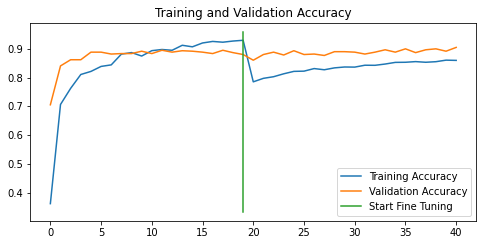

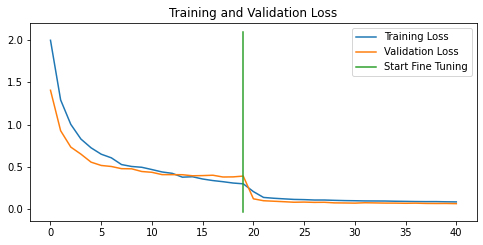

In [ ]:
# Let's compare the models
compare_histories(original_history=history_2,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=20)

## Viewing our experiment data on TensorBoard

> **Note:** Don't upload any private data on TensorBoard.dev. Because it will make the data public.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should `4 models)
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  -- name 'Transfer Learning experiments with 10 Food101 Classes' \
  -- description 'A series of different experiments with varying amount of data and fine-tuning' \
  -- one_shot # exits the uploader when finished